In [1]:
!git clone 'https://github.com/aakashvardhan/Transformers-Collab.git'

Cloning into 'Transformers-Collab'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (394/394), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 394 (delta 97), reused 343 (delta 46), pack-reused 0
Receiving objects: 100% (394/394), 13.88 MiB | 6.20 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [2]:
%cd Transformers-Collab

/content/Transformers-Collab


In [ ]:
!pip install torch

In [3]:
from utils import (create_dataloader,
                   get_img_batch,
                   show_img,
                   patchify_img,
                   show_conv2d_feature_maps)
from config import VITConfig
import torchvision
import torch
import torch.nn as nn
from torchinfo import summary

Installing torchinfo...


In [4]:
config = VITConfig()

train_dataloader, test_dataloader, class_names = create_dataloader(config)

In [5]:
image, label = get_img_batch(train_dataloader)

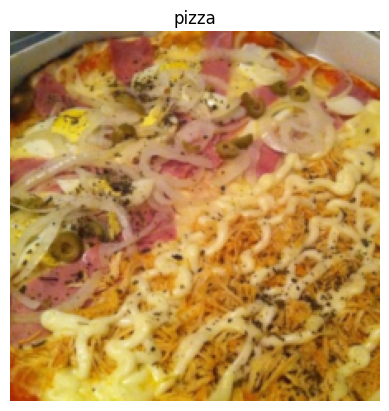

<Figure size 640x480 with 0 Axes>

In [6]:
show_img(image, label, class_names)

Number of patches per row: 14.0            
Number of patches per column: 14.0            
Total patches: 196.0            
Patch size: 16 pixels x 16 pixels


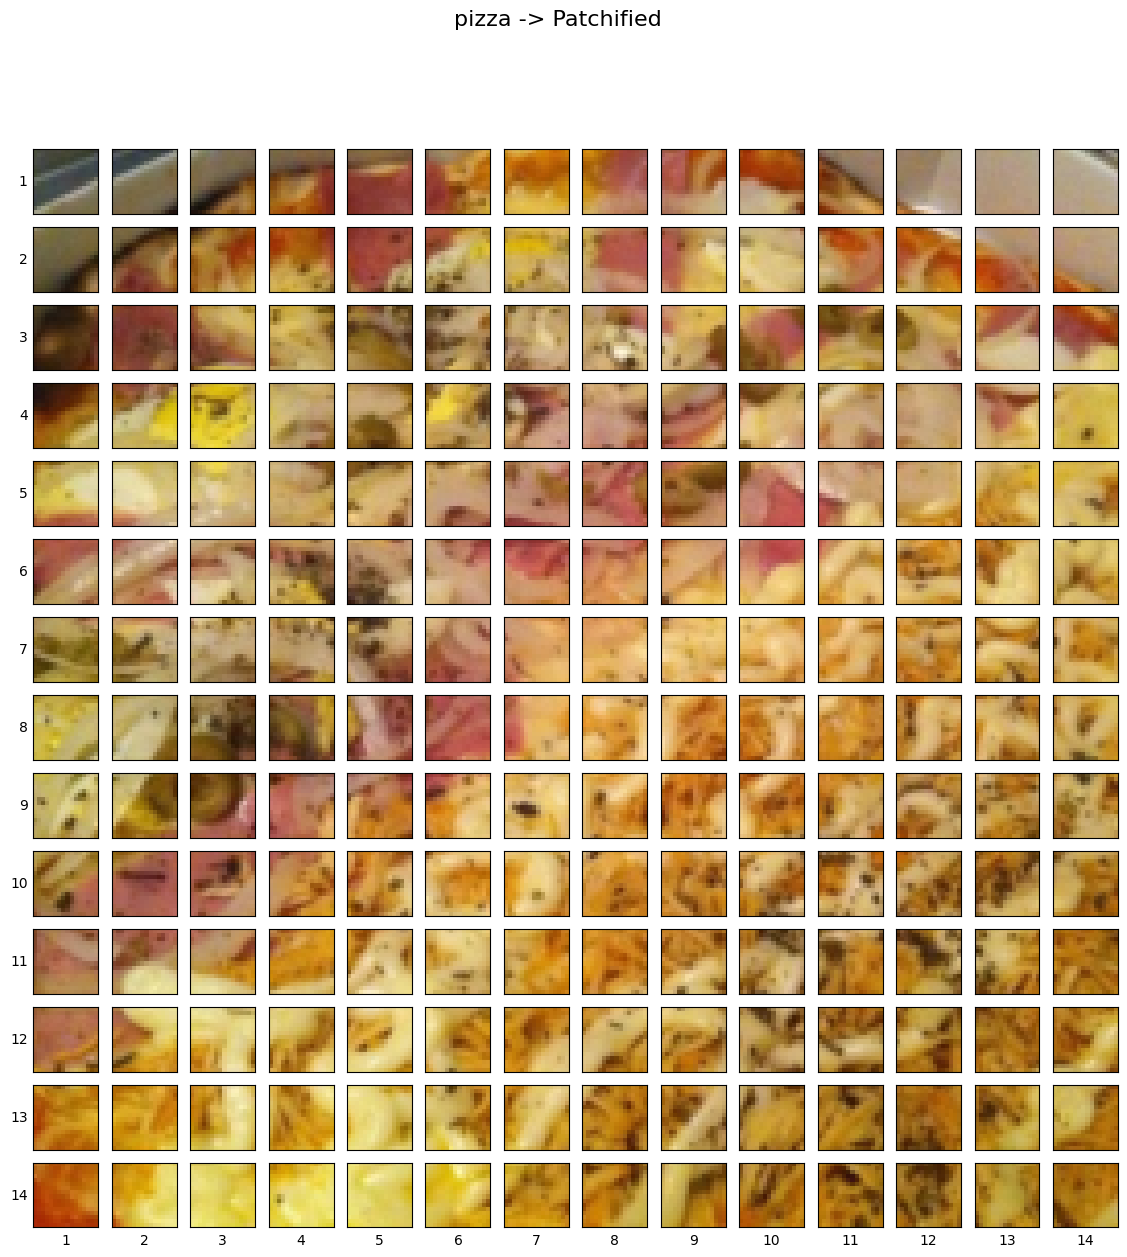

In [7]:
patchify_img(image, label, class_names, config)

Showing random convolutional feature maps from indexes: [288, 434, 190, 372, 297]


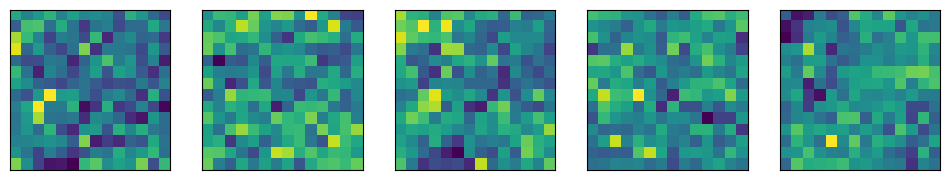

In [8]:
show_conv2d_feature_maps(image, config)

In [11]:
from utils import (get_vit_model_summary,
                   show_flattened_feature_map)
from vit_engine import train

Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


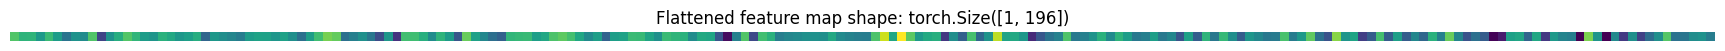

In [12]:
show_flattened_feature_map(image, config)

In [15]:
import sys
sys.path.append("/content/Transformers-Collab")
sys.path.append("/content/Transformers-Collab/models")

In [17]:
from models import transformer as t

In [19]:
vit = t.ViT(num_classes=len(class_names))

In [20]:
get_vit_model_summary(vit)

RuntimeError: ignored

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=config.lr, # Base LR from Table 3 for ViT-* ImageNet-1k
                            betas=config.betas, # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                            weight_decay=config.weight_decay) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=config.epoch,
                    device=config.device)

In [ ]:
from evaluation_utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
get_vit_model_summary(pretrained_vit)

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloader(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=config.n_epochs,
                                      device=config.device)

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

In [ ]:
!python main.py 'vit'